# Piezo-electro sensor

In [2]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
from matplotlib import pyplot as plt
from ipywidgets import widgets

%matplotlib inline

In [3]:
def force(t, omega):
    '''
    This function computes the force with which the piezo-electro sensor is stimulated.
    It is a harmonic force of amplitude 1 and angular frequency omega.

    Parameters:
    -----------
    t: time [s]
    omega: angular frequency [s^-1]

    Returns:
    --------
    (float) sin(omega*t)
    '''
    return np.sin(omega*t)

def q_vector_derivative(t, q_vector, omega, omega_0, xi, d):
    '''
    This function 

    Parameters:
    -----------
    t: time [s]
    q_vector: numpy array of the form (q,q'), where q is the charge [C]
    omega: angular frequency of force [s^-1]
    omega_0: natural frequency of the system [s^-1]
    xi: damping factor of the system [dimensionless]
    d: charge sensitivity parameter [C/N]

    Returns:
    --------
    (numpy array) derivative of [q,q']
    '''

    q0 = q_vector[0]
    q1 = q_vector[1]
    q0_d = q1
    q1_d = d * omega_0**2 * force(t, omega) - 2 * xi * omega_0 * q1 - omega_0**2 * q0

    return np.array([q0_d, q1_d])

def solve_differential_equation(periods, initial_condition, omega, omega_0=1, xi=1, d=1, alpha=0):
    '''
    Solve the differential equation q_vector(t)' = q_vector_derivative(t, omega, omega_0, xi, d, alpha)
    
    Parameters:
    ------------
    time_points: array-like sequence of time instants where to solve the equation
    inital_condition: array with the inistal condition [q_init, q_init']
    omega: angular frequency of force [s^-1]
    omega_0: natural frequency of the system [s^-1]
    xi: damping factor of the system [dimensionless]
    d: charge sensitivity parameter [C/N]
    alpha: non-linear factor [N^-2]

    Returns:
    --------
    (time_points, q_vector_solution)
    '''

    total_time = periods * 2 * np.pi / omega
    time_points = np.linspace(0, total_time, 1000)

    ode_solution = solve_ivp(q_vector_derivative, (0, total_time),
                             initial_condition, t_eval=time_points,
                             args=(omega, omega_0, xi, d))
                            
    return (ode_solution.t, ode_solution.y)

In [19]:
def plot_time_dependence(omega, xi):
    periods = 20
    initial_condition = np.array([0,0])
    t, y = solve_differential_equation(periods, initial_condition, omega=omega, xi=xi)
    
    fig, ax = plt.subplots()
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Charge [C]')
    ax.plot(t, y[0])
    fig.suptitle(r'Charge over time (20 periods)', fontsize=14)

widget_omega = widgets.FloatSlider(np.pi, min=0.1, max=np.pi*2, description='Omega')
widget_xi = widgets.FloatSlider(1, min=0, max=2, description='Xi')

widgets.interact(plot_time_dependence, omega = widget_omega, xi=widget_xi)

interactive(children=(FloatSlider(value=3.141592653589793, description='Omega', max=6.283185307179586, min=0.1…

<function __main__.plot_time_dependence(omega, xi)>

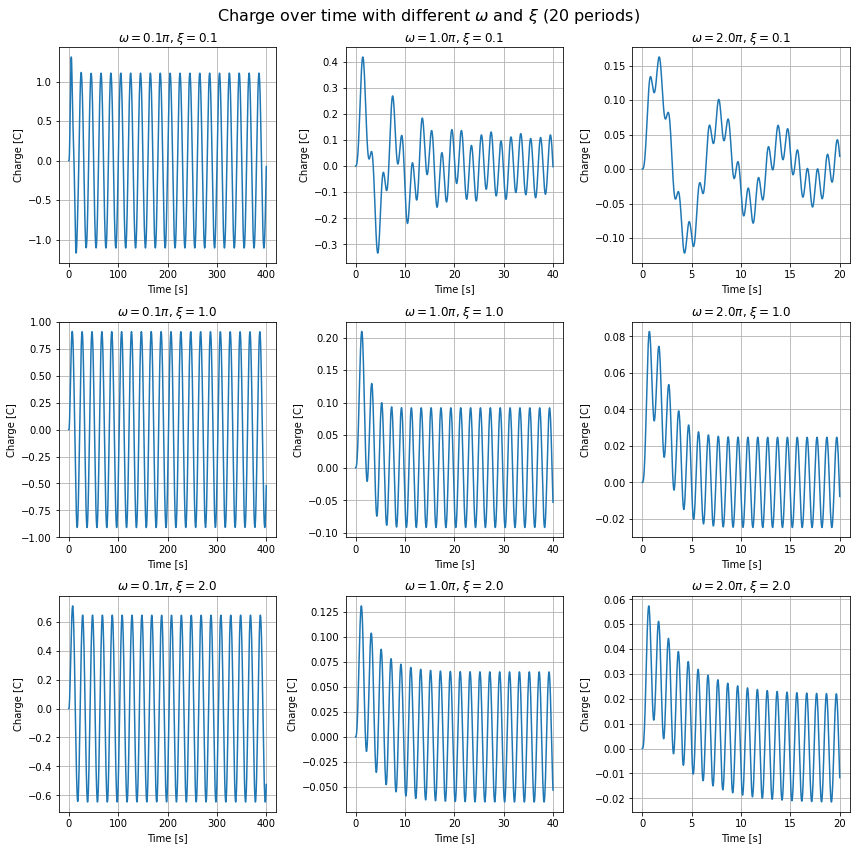

In [10]:
periods = 20                                 #the differential equation is solved for a time of 10 periods
initial_condition = np.array([0,0])

omegas = np.array([0.1, 1, 2]) * np.pi
xis = np.array([0.1, 1, 2])
parameters = np.array(np.meshgrid(omegas, xis)).reshape(2,9)
solutions = np.zeros((2,1000, 9))
time_points = np.zeros((1000, 9))

for i in range(0, parameters.shape[-1]):
    time_points[...,i], solutions[...,i] = solve_differential_equation(periods, initial_condition, omega=parameters[0,i], xi=parameters[1,i])

fig = plt.figure(figsize=(12,12))
axs = fig.subplots(3, 3)

axs = axs.reshape(9)
for i in range(0,9):
    axs[i].plot(time_points[:,i], solutions[0,:,i])
    axs[i].set_xlabel('Time [s]')
    axs[i].set_ylabel('Charge [C]')
    axs[i].grid(True)
    axs[i].set_title(r'$\omega=${omega}$\pi$, $\xi=${xi}'.format(omega=parameters[0,i]/np.pi, xi=parameters[1,i]))

fig.suptitle(r'Charge over time with different $\omega$ and $\xi$ (20 periods)', fontsize=16)
fig.tight_layout()